In [154]:
from __future__ import print_function
import os
from os.path import splitext, join, isfile, isdir, basename
import argparse
import numpy as np
from scipy import misc, ndimage
from keras import backend as K
from keras.models import model_from_json, load_model
import tensorflow as tf
import layers_builder as layers
from glob import glob
from utils import utils
from keras.utils.generic_utils import CustomObjectScope
import cv2
import math
# -- Fix for macos, uncomment it
# import matplotlib
# matplotlib.use('TkAgg')
# --
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

from imageio import imread
# These are the means for the ImageNet pretrained ResNet
DATA_MEAN = np.array([[[123.68, 116.779, 103.939]]])  # RGB order

In [2]:
class PSPNet(object):
    """Pyramid Scene Parsing Network by Hengshuang Zhao et al 2017"""

    def __init__(self, nb_classes, resnet_layers, input_shape, weights):
        self.input_shape = input_shape
        self.num_classes = nb_classes

        json_path = join("weights", "keras", weights + ".json")
        h5_path = join("weights", "keras", weights + ".h5")
        if 'pspnet' in weights:
            if os.path.isfile(json_path) and os.path.isfile(h5_path):
                print("Keras model & weights found, loading...")
                with CustomObjectScope({'Interp': layers.Interp}):
                    with open(json_path) as file_handle:
                        self.model = model_from_json(file_handle.read())
                self.model.load_weights(h5_path)
            else:
                print("No Keras model & weights found, import from npy weights.")
                self.model = layers.build_pspnet(nb_classes=nb_classes,
                                                 resnet_layers=resnet_layers,
                                                 input_shape=self.input_shape)
                self.set_npy_weights(weights)
        else:
            print('Load pre-trained weights')
            self.model = load_model(weights)

    def predict(self, img, flip_evaluation=False):
        """
        Predict segementation for an image.
        Arguments:
            img: must be rowsxcolsx3
        """

        if img.shape[0:2] != self.input_shape:
            print(
                "Input %s not fitting for network size %s, resizing. You may want to try sliding prediction for better results." % (
                img.shape[0:2], self.input_shape))
            img = misc.imresize(img, self.input_shape)

        img = img - DATA_MEAN
        img = img[:, :, ::-1]  # RGB => BGR
        img = img.astype('float32')

        probs = self.feed_forward(img, flip_evaluation)

        return probs

    def predict_sliding(self, full_img, flip_evaluation):
        """
        Predict on tiles of exactly the network input shape.
        This way nothing gets squeezed.
        """
        tile_size = self.input_shape
        classes = self.num_classes
        overlap = 1 / 3

        stride = math.ceil(tile_size[0] * (1 - overlap))
        tile_rows = max(int(math.ceil((full_img.shape[0] - tile_size[0]) / stride) + 1), 1)  # strided convolution formula
        tile_cols = max(int(math.ceil((full_img.shape[1] - tile_size[1]) / stride) + 1), 1)
        print("Need %i x %i prediction tiles @ stride %i px" % (tile_cols, tile_rows, stride))
        full_probs = np.zeros((full_img.shape[0], full_img.shape[1], classes))
        count_predictions = np.zeros((full_img.shape[0], full_img.shape[1], classes))
        tile_counter = 0
        for row in range(tile_rows):
            for col in range(tile_cols):
                x1 = int(col * stride)
                y1 = int(row * stride)
                x2 = min(x1 + tile_size[1], full_img.shape[1])
                y2 = min(y1 + tile_size[0], full_img.shape[0])
                x1 = max(int(x2 - tile_size[1]), 0)  # for portrait images the x1 underflows sometimes
                y1 = max(int(y2 - tile_size[0]), 0)  # for very few rows y1 underflows

                img = full_img[y1:y2, x1:x2]
                padded_img = self.pad_image(img, tile_size)
                plt.imshow(padded_img)
                plt.show()
                tile_counter += 1
                print("Predicting tile %i" % tile_counter)
                padded_prediction = self.predict(padded_img, flip_evaluation)
                prediction = padded_prediction[0:img.shape[0], 0:img.shape[1], :]
                count_predictions[y1:y2, x1:x2] += 1
                full_probs[y1:y2, x1:x2] += prediction  # accumulate the predictions also in the overlapping regions

        # average the predictions in the overlapping regions
        full_probs /= count_predictions
        # visualize normalization Weights
        # plt.imshow(np.mean(count_predictions, axis=2))
        # plt.show()
        return full_probs

    @staticmethod
    def pad_image(img, target_size):
        """Pad an image up to the target size."""
        rows_missing = target_size[0] - img.shape[0]
        cols_missing = target_size[1] - img.shape[1]
        padded_img = np.pad(img, ((0, rows_missing), (0, cols_missing), (0, 0)), 'constant')
        return padded_img

    def predict_multi_scale(self, img, flip_evaluation, sliding_evaluation, scales):
        """Predict an image by looking at it with different scales."""

        full_probs = np.zeros((img.shape[0], img.shape[1], self.num_classes))
        h_ori, w_ori = img.shape[:2]

        print("Started prediction...")
        for scale in scales:
            print("Predicting image scaled by %f" % scale)
            scaled_img = misc.imresize(img, size=scale, interp="bilinear")

            if sliding_evaluation:
                scaled_probs = self.predict_sliding(scaled_img, flip_evaluation)
            else:
                scaled_probs = self.predict(scaled_img, flip_evaluation)

            # scale probs up to full size
            # visualize_prediction(probs)
            probs = cv2.resize(scaled_probs, (w_ori, h_ori))
            full_probs += probs
        full_probs /= len(scales)
        print("Finished prediction...")

        return full_probs

    def feed_forward(self, data, flip_evaluation=False):
        assert data.shape == (self.input_shape[0], self.input_shape[1], 3)

        if flip_evaluation:
            print("Predict flipped")
            input_with_flipped = np.array(
                [data, np.flip(data, axis=1)])
            prediction_with_flipped = self.model.predict(input_with_flipped)
            prediction = (prediction_with_flipped[
                          0] + np.fliplr(prediction_with_flipped[1])) / 2.0
        else:
            prediction = self.model.predict(np.expand_dims(data, 0))[0]
        return prediction

    def set_npy_weights(self, weights_path):
        npy_weights_path = join("weights", "npy", weights_path + ".npy")
        json_path = join("weights", "keras", weights_path + ".json")
        h5_path = join("weights", "keras", weights_path + ".h5")

        print("Importing weights from %s" % npy_weights_path)
        weights = np.load(npy_weights_path, encoding='bytes').item()
        for layer in self.model.layers:
            print(layer.name)
            if layer.name[:4] == 'conv' and layer.name[-2:] == 'bn':
                mean = weights[layer.name.encode()][
                    'mean'.encode()].reshape(-1)
                variance = weights[layer.name.encode()][
                    'variance'.encode()].reshape(-1)
                scale = weights[layer.name.encode()][
                    'scale'.encode()].reshape(-1)
                offset = weights[layer.name.encode()][
                    'offset'.encode()].reshape(-1)

                self.model.get_layer(layer.name).set_weights(
                    [scale, offset, mean, variance])

            elif layer.name[:4] == 'conv' and not layer.name[-4:] == 'relu':
                try:
                    weight = weights[layer.name.encode()]['weights'.encode()]
                    self.model.get_layer(layer.name).set_weights([weight])
                except Exception as err:
                    biases = weights[layer.name.encode()]['biases'.encode()]
                    self.model.get_layer(layer.name).set_weights([weight,
                                                                  biases])
        print('Finished importing weights.')

        print("Writing keras model & weights")
        json_string = self.model.to_json()
        with open(json_path, 'w') as file_handle:
            file_handle.write(json_string)
        self.model.save_weights(h5_path)
        print("Finished writing Keras model & weights")


class PSPNet50(PSPNet):
    """Build a PSPNet based on a 50-Layer ResNet."""

    def __init__(self, nb_classes, weights, input_shape):
        PSPNet.__init__(self, nb_classes=nb_classes, resnet_layers=50,
                        input_shape=input_shape, weights=weights)


class PSPNet101(PSPNet):
    """Build a PSPNet based on a 101-Layer ResNet."""

    def __init__(self, nb_classes, weights, input_shape):
        PSPNet.__init__(self, nb_classes=nb_classes, resnet_layers=101,
                        input_shape=input_shape, weights=weights)


def main(args):
    # Handle input and output args
    images = glob(args.glob_path) if args.glob_path else [args.input_path, ]
    if args.glob_path:
        fn, ext = splitext(args.output_path)
        if ext:
            parser.error("output_path should be a folder for multiple file input")
        if not isdir(args.output_path):
            os.mkdir(args.output_path)

    # Predict
    os.environ["CUDA_VISIBLE_DEVICES"] = args.id

    sess = tf.Session()
    K.set_session(sess)

    with sess.as_default():
        print(args)
        if not args.weights:
            if "pspnet50" in args.model:
                pspnet = PSPNet50(nb_classes=150, input_shape=(473, 473),
                                  weights=args.model)
            elif "pspnet101" in args.model:
                if "cityscapes" in args.model:
                    pspnet = PSPNet101(nb_classes=19, input_shape=(713, 713),
                                       weights=args.model)
                if "voc2012" in args.model:
                    pspnet = PSPNet101(nb_classes=21, input_shape=(473, 473),
                                       weights=args.model)

            else:
                print("Network architecture not implemented.")
        else:
            pspnet = PSPNet50(nb_classes=2, input_shape=(
                768, 480), weights=args.weights)

        EVALUATION_SCALES = [1.0]
        if args.multi_scale:
            EVALUATION_SCALES = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]  # must be all floats! Taken from original paper

        for i, img_path in enumerate(images):
            print("Processing image {} / {}".format(i + 1, len(images)))
            img = imread(img_path, pilmode='RGB')

            probs = pspnet.predict_multi_scale(img, args.flip, args.sliding, EVALUATION_SCALES)

            cm = np.argmax(probs, axis=2)
            pm = np.max(probs, axis=2)

            colored_class_image = utils.color_class_image(cm, args.model)
            alpha_blended = 0.5 * colored_class_image + 0.5 * img

            if args.glob_path:
                input_filename, ext = splitext(basename(img_path))
                filename = join(args.output_path, input_filename)
            else:
                filename, ext = splitext(args.output_path)

#             misc.imsave(filename + "_seg_read" + ext, cm)
#             misc.imsave(filename + "_seg" + ext, colored_class_image)
#             misc.imsave(filename + "_probs" + ext, pm)
#             misc.imsave(filename + "_seg_blended" + ext, alpha_blended)



Keras model & weights found, loading...
Processing image 1 / 1
Started prediction...
Predicting image scaled by 1.000000
Need 3 x 4 prediction tiles @ stride 316 px


C:\Users\mb910\Anaconda3\envs\segmentation_env\lib\site-packages\ipykernel_launcher.py:108: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


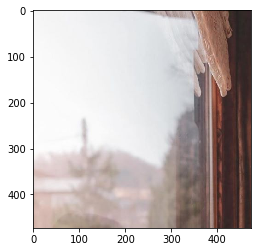

Predicting tile 1
Predict flipped


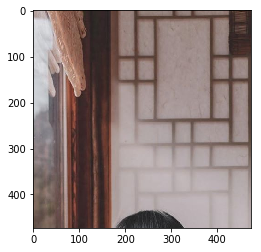

Predicting tile 2
Predict flipped


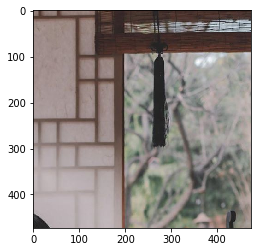

Predicting tile 3
Predict flipped


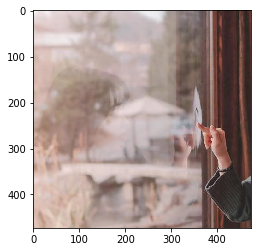

Predicting tile 4
Predict flipped


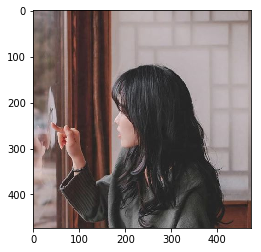

Predicting tile 5
Predict flipped


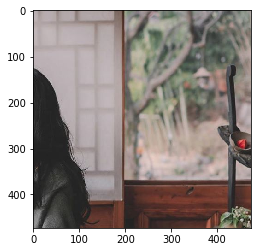

Predicting tile 6
Predict flipped


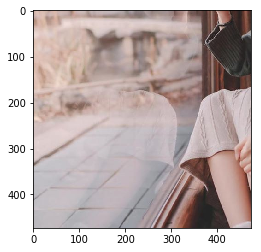

Predicting tile 7
Predict flipped


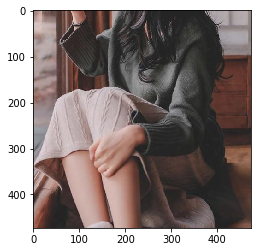

Predicting tile 8
Predict flipped


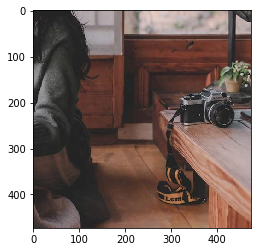

Predicting tile 9
Predict flipped


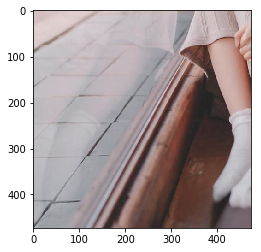

Predicting tile 10
Predict flipped


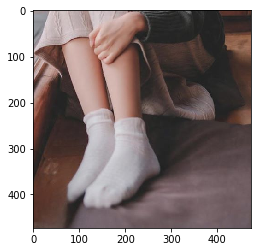

Predicting tile 11
Predict flipped


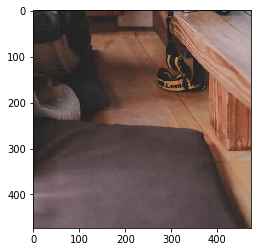

Predicting tile 12
Predict flipped
Finished prediction...


In [205]:
images = glob('example_images/0002.png') # if args.glob_path else [args.input_path, ]
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sess = tf.Session()
K.set_session(sess)
pspnet = PSPNet50(nb_classes=150, input_shape=(473, 473),
                                  weights='pspnet50_ade20k')
EVALUATION_SCALES = [1.0]
for i, img_path in enumerate(images):
    print("Processing image {} / {}".format(i + 1, len(images)))
    img = imread(img_path, pilmode='RGB')

    probs = pspnet.predict_multi_scale(img, True, True, EVALUATION_SCALES)

    cm = np.argmax(probs, axis=2)
    pm = np.max(probs, axis=2)

    colored_class_image = utils.color_class_image(cm, 'pspnet50_ade20k')
    alpha_blended = 0.5 * colored_class_image + 0.5 * img

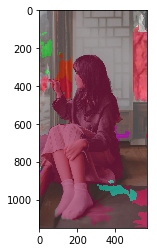

In [206]:
plt.imshow(alpha_blended.round().astype("uint8")[200:, bbox[0][0]:bbox[0][2]])

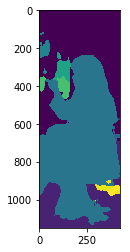

In [235]:
plt.imshow(cm[200:, bbox[0][0]:bbox[0][2]])

In [228]:
xx = cm[600:, bbox[0][0]:bbox[0][2]]
unique_elements, counts_elements = np.unique(xx, return_counts=True)

In [229]:
unique_elements[np.where(counts_elements==max(counts_elements))][0]

12

In [230]:
a,b = np.where(xx == unique_elements[np.where(counts_elements==max(counts_elements))][0])

In [231]:
imgg[a,b]

array([[ 79,  47,  48],
       [135, 101,  99],
       [227, 193, 184],
       ...,
       [105,  89,  92],
       [105,  89,  92],
       [105,  89,  92]], dtype=uint8)

In [211]:
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

img = cv2.imread('example_images/0002.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bbox, label, conf = cv.detect_common_objects(img)
output_image = draw_bbox(img, bbox, label, conf)

bbox

[[319, 443, 747, 1289]]

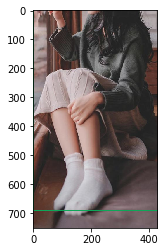

In [232]:
# plt.imshow(output_image)
plt.imshow(img[600:, bbox[0][0]:bbox[0][2]])
imgg = img[600:, bbox[0][0]:bbox[0][2]]

In [4]:
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-m', '--model', type=str, default='pspnet101_voc2012',
#                         help='Model/Weights to use',
#                         choices=['pspnet50_ade20k',
#                                  'pspnet101_cityscapes',
#                                  'pspnet101_voc2012'])
#     parser.add_argument('-w', '--weights', type=str, default=None)
#     parser.add_argument('-i', '--input_path', type=str, default='example_images/ade20k.jpg',
#                         help='Path the input image')
#     parser.add_argument('-g', '--glob_path', type=str, default=None,
#                         help='Glob path for multiple images')
#     parser.add_argument('-o', '--output_path', type=str, default='example_results/ade20k.jpg',
#                         help='Path to output')
#     parser.add_argument('--id', default="0")
#     parser.add_argument('--input_size', type=int, default=500)
#     parser.add_argument('-s', '--sliding', action='store_true',
#                         help="Whether the network should be slided over the original image for prediction.")
#     parser.add_argument('-f', '--flip', action='store_true', default=True,
#                         help="Whether the network should predict on both image and flipped image.")
#     parser.add_argument('-ms', '--multi_scale', action='store_true',
#                         help="Whether the network should predict on multiple scales.")

#     args = parser.parse_args()

#     main(args)


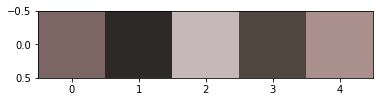

In [239]:
# arrange the cluster_centers of KMeans output according to frequency of each label
def arrange_cluster_centers(clt):
    lb_counts = Counter(clt.labels_)
    
    tmp_dict = {}
    for idx, pixel in enumerate(clt.cluster_centers_):
        tmp_dict[ lb_counts[idx] ] = pixel  # { frequency of label : color of label } mapping
    
    centers_aranged_dict = dict(sorted(tmp_dict.items(), reverse=True))  # arrange the dict according to key (frequency of label)

    centers_aranged_arr = np.array(list(centers_aranged_dict.values()))  # pack colors into one array
    centers_aranged_arr = centers_aranged_arr.round().astype("uint8")  # tranform the type to integer
    centers_aranged_arr = np.expand_dims(centers_aranged_arr, 0)  # add one dimension for visualization
    return centers_aranged_arr


expected_num_col = 5 #cluster number

# Extract dominant color using KMeans
clt = KMeans(n_clusters = expected_num_col)
clt.fit(imgg[a,b])


# Visualization
centers_aranged_arr = arrange_cluster_centers(clt)
plt.imshow(centers_aranged_arr)
plt.show()

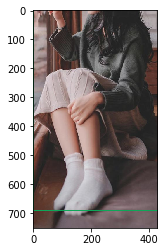

In [234]:
plt.imshow(imgg)